In [6]:
!pip install modal-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 2.0 MB/s eta 0:00:00 0:00:01


In [7]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 60.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer,

In [3]:
!pip install modAL

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 722.3 kB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.8/466.8 kB 3.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.1 MB/s eta 0:00:00
  Created wheel for grpclib: filename=grpclib-0.4.7-py3-none-any.whl size=76220 sha256=6319fc5ae4273df664f7e5820b765580eea763a53cc9e0f1cdafaabd09d06579
  Stored in directory: /root/.cache/pip/wheels/05/c0/1c/3d807409d0c67efeab2949832ba409205b1b6fe03f739ae4c1
Successfully built grpclib


In [8]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling, classifier_uncertainty
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [9]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
len(X_train)

50000

CNN model

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical

def create_model():
    model = Sequential()

    # First convolutional block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Second convolutional block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Flatten the output for the fully connected layers
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print the model summary
    model.summary()
    return model

In [12]:
# Use predict instead of predict_proba
def predict_proba(self, X, **predict_proba_kwargs):
    return self.estimator.predict(X, **predict_proba_kwargs)
ActiveLearner.predict_proba = predict_proba

# ***Random Sampling:***

prepare data

In [13]:
#labeled data
initial_idx = slice(400)
X_initial_1 = X_train[initial_idx]
y_initial_1 = y_train[initial_idx]


#unlabeled data
X_pool_1 = np.delete(X_train, initial_idx, axis=0)
y_pool_1 = np.delete(y_train, initial_idx, axis=0)

pool_indices = np.arange(len(X_pool_1))

In [14]:
def random_sampling(classifier, X_pool_1):
    n_samples = len(X_pool_1)
    query_indices = np.random.choice(range(n_samples), size=1000, replace=False)
    return query_indices, X_pool_1[query_indices]

In [15]:
learner = ActiveLearner(
    estimator=create_model(),
    query_strategy = random_sampling,
    X_training=X_initial_1,
    y_training=y_initial_1
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,350,826 (12.78 MB)

 Trainable params: 3,349,418 (12.78 MB)

 Non-trainable params: 1,408 (5.50 KB)

I0000 00:00:1714624458.494714     153 service.cc:145] XLA service 0x7914c8007430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714624458.494757     153 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1714624458.494762     153 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 9/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1616 - loss: 3.3885  

I0000 00:00:1714624468.447883     153 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 625ms/step - accuracy: 0.1731 - loss: 3.3923


232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6470 - loss: 1.0226
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6787 - loss: 0.9338
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7119 - loss: 0.8317
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7371 - loss: 0.7745
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7587 - loss: 0.6984
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7744 - loss: 0.6595
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
419/419 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7852 - loss: 0.6242
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8030 - loss: 0.5768
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 

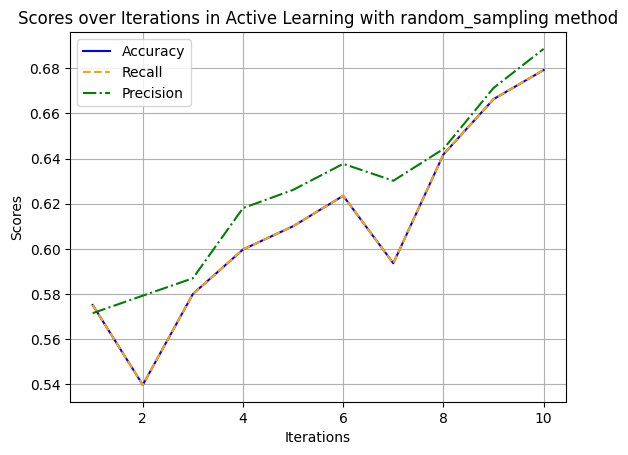

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

n_queries = 10
accuracies = [] 
recalls  = []
precisions = []
# Active learning loop
for _ in range(n_queries):
    query_idx, query_instance = learner.query(X_pool_1)
    X_query, y_query = X_pool_1[query_idx], y_pool_1[query_idx]

    
    learner.teach(X=X_query, y=y_query)
    
    X_pool_1 = np.delete(X_pool_1, query_idx, axis=0)
    y_pool_1 = np.delete(y_pool_1, query_idx, axis=0)
    print(len(X_query))
    y_pred = learner.predict(X_test)
    
    acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

    accuracies.append(acc)
    recalls.append(recall_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted'))
    precisions.append(precision_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted'))
    
    # Evaluate the model periodically
    if (_ + 1) % 10 == 0:
        print(f"Query {_+1}, Accuracy: {acc}")
        
plt.plot(range(1, n_queries + 1), accuracies, label='Accuracy', linestyle='-', color='blue')
plt.plot(range(1, n_queries + 1), recalls, label='Recall', linestyle='--', color='orange')
plt.plot(range(1, n_queries + 1), precisions, label='Precision', linestyle='-.', color='green')
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('Scores over Iterations in Active Learning with random_sampling method')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
y_pred = learner.predict(X_test)
acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
print(f"Accuracy: {acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.6792


In [20]:
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
precision = precision_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')
recall = recall_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.6885646321539731
Recall: 0.6792
F1-score: 0.6819459407497815


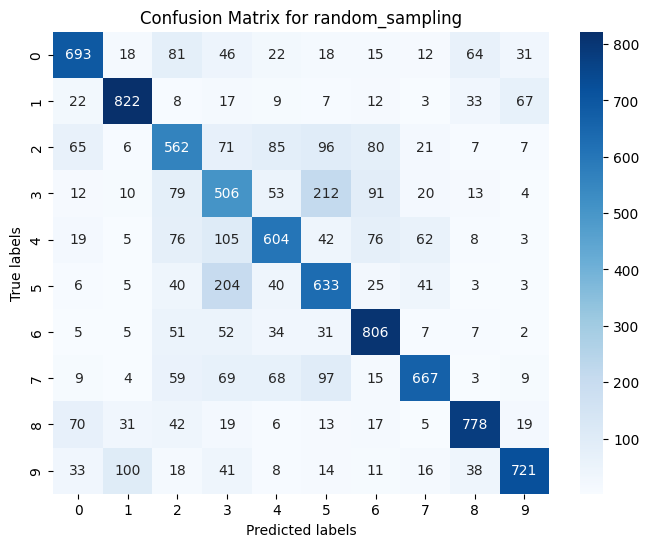

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have y_test and y_pred

# Calculate confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(cm.shape[1]), yticklabels=range(cm.shape[0]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for random_sampling')
plt.show()

# ***margin_sampling:***

prepare data

In [29]:
#labeled data
initial_idx = slice(400)
X_initial_2 = X_train[initial_idx]
y_initial_2 = y_train[initial_idx]


#unlabeled data
X_pool_2 = np.delete(X_train, initial_idx, axis=0)
y_pool_2 = np.delete(y_train, initial_idx, axis=0)

In [30]:
learner = ActiveLearner(
    estimator=create_model(),
    query_strategy = margin_sampling,
    X_training=X_initial_2,
    y_training=y_initial_2
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,350,826 (12.78 MB)

 Trainable params: 3,349,418 (12.78 MB)

 Non-trainable params: 1,408 (5.50 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 573ms/step - accuracy: 0.1747 - loss: 3.5371


1332/1332 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6415 - loss: 1.0352
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1300/1300 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6840 - loss: 0.9216
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1269/1269 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6913 - loss: 0.8681
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
357/357 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6993 - loss: 0.8683
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7041 - loss: 0.8411
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
419/419 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7211 - loss: 0.7999
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1144/1144 ━━━━━━

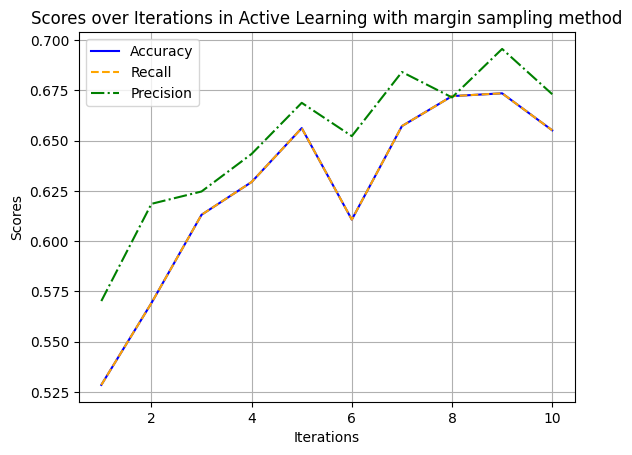

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

accuracies = [] 
recalls  = []
precisions = []
# Active learning loop
n_queries = 10
# Active learning loop
for _ in range(n_queries):
    query_idx, query_instance = learner.query(X_pool_2, n_instances=1000)   
    X_query, y_query = X_pool_2[query_idx], y_pool_2[query_idx]

    
    learner.teach(X=X_query, y=y_query)
    
    X_pool_2 = np.delete(X_pool_2, query_idx, axis=0)
    y_pool_2 = np.delete(y_pool_2, query_idx, axis=0)
    print(len(X_query))
    y_pred = learner.predict(X_test)
    
    acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

    accuracies.append(acc)
    recalls.append(recall_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted', zero_division='warn'))
    precisions.append(precision_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted', zero_division='warn'))
    
    # Evaluate the model periodically
    if (_ + 1) % 10 == 0:
        print(f"Query {_+1}, Accuracy: {acc}")
        
plt.plot(range(1, n_queries + 1), accuracies, label='Accuracy', linestyle='-', color='blue')
plt.plot(range(1, n_queries + 1), recalls, label='Recall', linestyle='--', color='orange')
plt.plot(range(1, n_queries + 1), precisions, label='Precision', linestyle='-.', color='green')
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('Scores over Iterations in Active Learning with margin sampling method')
plt.legend()
plt.grid(True)

plt.show()

In [33]:
y_pred = learner.predict(X_test)
acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
print(f"Accuracy: {acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.6551


In [34]:
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
precision = precision_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')
recall = recall_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.6730467085454257
Recall: 0.6551
F1-score: 0.6499533698046324


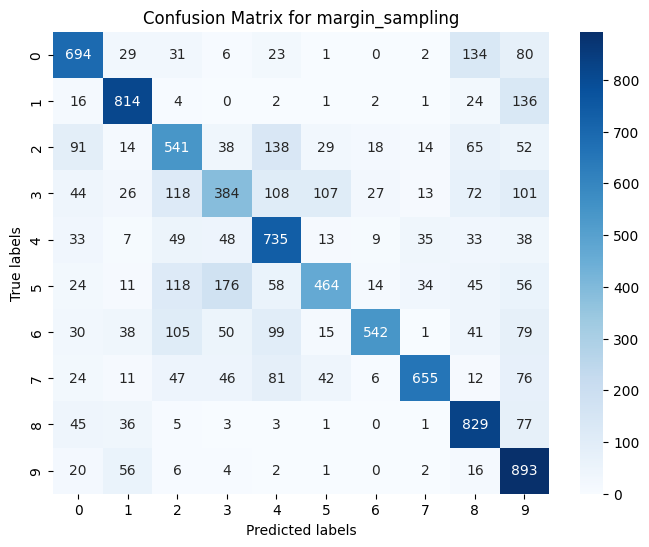

In [35]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(cm.shape[1]), yticklabels=range(cm.shape[0]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for margin_sampling')
plt.show()

# ***entropy_sampling:***

prepare data

In [41]:
#labeled data
initial_idx = slice(400)
X_initial_3 = X_train[initial_idx]
y_initial_3 = y_train[initial_idx]


#unlabeled data
X_pool_3 = np.delete(X_train, initial_idx, axis=0)
y_pool_3 = np.delete(y_train, initial_idx, axis=0)

In [42]:
learner = ActiveLearner(
    estimator=create_model(),
    query_strategy = entropy_sampling,
    X_training=X_initial_3,
    y_training=y_initial_3
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,350,826 (12.78 MB)

 Trainable params: 3,349,418 (12.78 MB)

 Non-trainable params: 1,408 (5.50 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 521ms/step - accuracy: 0.1667 - loss: 3.6008


1550/1550 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.3529 - loss: 2.6302
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1519/1519 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4461 - loss: 1.9117
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1488/1488 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.4953 - loss: 1.6094
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1457/1457 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5633 - loss: 1.3655
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6296 - loss: 1.1649
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6613 - loss: 1.0281
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6514 - loss: 1.0505
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6480 - loss: 1.0153
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1300/1300 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6678 - loss: 0.9846
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1269/1269 ━━━━━━

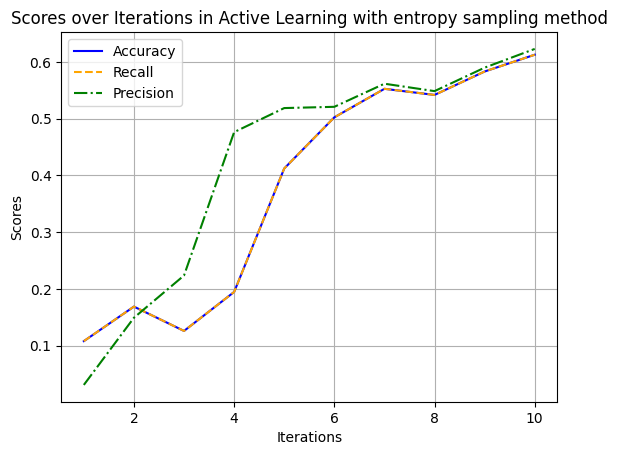

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

accuracies = [] 
recalls  = []
precisions = []
# Active learning loop
n_queries = 10
# Active learning loop
for _ in range(n_queries):
    query_idx, query_instance = learner.query(X_pool_3, n_instances=1000)
    X_query, y_query = X_pool_3[query_idx], y_pool_3[query_idx]

    
    learner.teach(X=X_query, y=y_query)
    
    X_pool_3 = np.delete(X_pool_3, query_idx, axis=0)
    y_pool_3 = np.delete(y_pool_3, query_idx, axis=0)
    print(len(X_query))
    y_pred = learner.predict(X_test)
    
    acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

    accuracies.append(acc)
    recalls.append(recall_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted', zero_division='warn'))
    precisions.append(precision_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted', zero_division='warn'))
    
    # Evaluate the model periodically
    if (_ + 1) % 10 == 0:
        print(f"Query {_+1}, Accuracy: {acc}")
        
plt.plot(range(1, n_queries + 1), accuracies, label='Accuracy', linestyle='-', color='blue')
plt.plot(range(1, n_queries + 1), recalls, label='Recall', linestyle='--', color='orange')
plt.plot(range(1, n_queries + 1), precisions, label='Precision', linestyle='-.', color='green')
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('Scores over Iterations in Active Learning with entropy sampling method')
plt.legend()
plt.grid(True)

plt.show()

In [44]:
y_pred = learner.predict(X_test)
acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
print(f"Accuracy: {acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.6127


In [45]:
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
precision = precision_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')
recall = recall_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.6229289827673663
Recall: 0.6127
F1-score: 0.6054162385040762


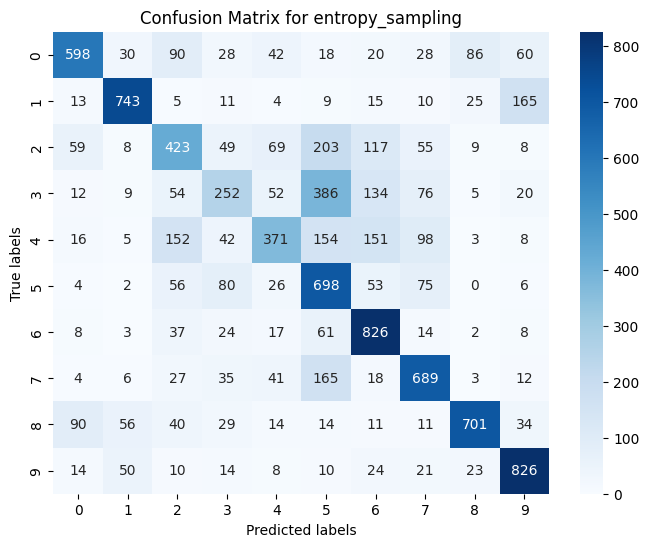

In [46]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have y_test and y_pred

# Calculate confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(cm.shape[1]), yticklabels=range(cm.shape[0]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for entropy_sampling')
plt.show()

# ***uncertainty_sampling (Least Confidence Sampling):***

prepare data

In [47]:
#labeled data
initial_idx = slice(400)
X_initial_4 = X_train[initial_idx]
y_initial_4 = y_train[initial_idx]


#unlabeled data
X_pool_4 = np.delete(X_train, initial_idx, axis=0)
y_pool_4 = np.delete(y_train, initial_idx, axis=0)

In [48]:
from modAL.disagreement import vote_entropy_sampling

learner = ActiveLearner(
    estimator=create_model(),
    query_strategy = uncertainty_sampling,
    X_training=X_initial_4,
    y_training=y_initial_4
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,350,826 (12.78 MB)

 Trainable params: 3,349,418 (12.78 MB)

 Non-trainable params: 1,408 (5.50 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 526ms/step - accuracy: 0.1533 - loss: 3.5647


1550/1550 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.3722 - loss: 2.5838
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1519/1519 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4307 - loss: 2.0415
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1488/1488 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.5209 - loss: 1.5661
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1457/1457 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5617 - loss: 1.3311
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6001 - loss: 1.2347
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1394/1394 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6438 - loss: 1.0592
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6438 - loss: 1.0392
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6512 - loss: 0.9954
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1300/1300 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6761 - loss: 0.9291
1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1269/1269 ━━━━━━

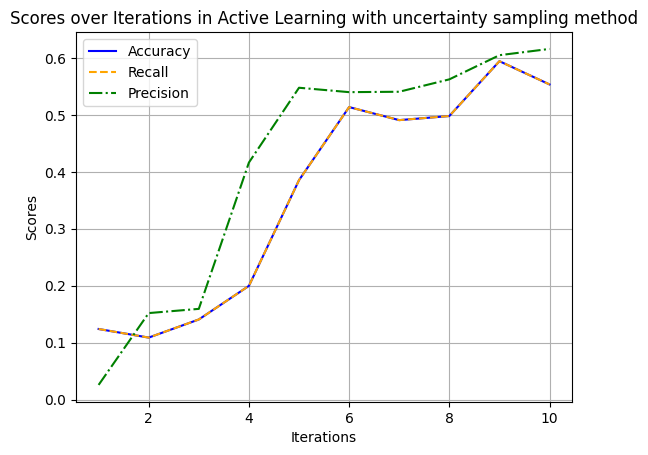

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

accuracies = [] 
recalls  = []
precisions = []
# Active learning loop
n_queries = 10
# Active learning loop
for _ in range(n_queries):
    query_idx, query_instance = learner.query(X_pool_4, n_instances=1000)
    X_query, y_query = X_pool_4[query_idx], y_pool_4[query_idx]

    
    learner.teach(X=X_query, y=y_query)
    
    X_pool_4 = np.delete(X_pool_4, query_idx, axis=0)
    y_pool_4 = np.delete(y_pool_4, query_idx, axis=0)
    print(len(X_query))
    y_pred = learner.predict(X_test)
    
    acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

    accuracies.append(acc)
    recalls.append(recall_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted', zero_division='warn'))
    precisions.append(precision_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted', zero_division='warn'))
    
    # Evaluate the model periodically
    if (_ + 1) % 10 == 0:
        print(f"Query {_+1}, Accuracy: {acc}")
        
plt.plot(range(1, n_queries + 1), accuracies, label='Accuracy', linestyle='-', color='blue')
plt.plot(range(1, n_queries + 1), recalls, label='Recall', linestyle='--', color='orange')
plt.plot(range(1, n_queries + 1), precisions, label='Precision', linestyle='-.', color='green')
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('Scores over Iterations in Active Learning with uncertainty sampling method')
plt.legend()
plt.grid(True)

plt.show()

In [50]:
y_pred = learner.predict(X_test)
acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
print(f"Accuracy: {acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.5535


In [51]:
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
precision = precision_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')
recall = recall_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.6158464855483307
Recall: 0.5535
F1-score: 0.5608629042898735


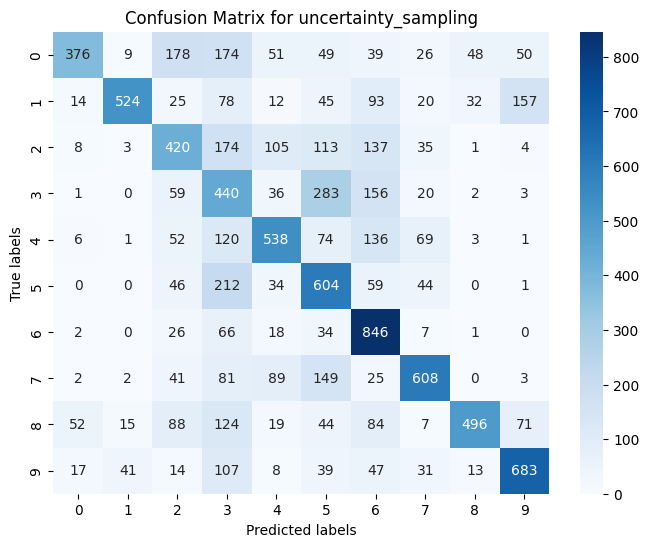

In [52]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have y_test and y_pred

# Calculate confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(cm.shape[1]), yticklabels=range(cm.shape[0]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for uncertainty_sampling')
plt.show()

# ***passive learning:***

In [53]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

# First convolutional block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second convolutional block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Flatten the output for the fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,350,826 (12.78 MB)

 Trainable params: 3,349,418 (12.78 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [55]:
# Train the model
history = model.fit(x_train, y_train, epochs=10)


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.4227 - loss: 1.8944
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6573 - loss: 0.9848
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7052 - loss: 0.8412
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7427 - loss: 0.7395
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7651 - loss: 0.6761
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7804 - loss: 0.6272
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8057 - loss: 0.5573
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8177 - loss: 0.5166
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8328 - loss: 0.4781
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8473 - loss: 0.4344


In [56]:
# Evaluate the model on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')


313/313 - 2s - 6ms/step - accuracy: 0.7994 - loss: 0.6221
Test accuracy: 0.7993999719619751


In [57]:
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
precision = precision_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted')
recall = recall_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted', zero_division='warn')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred_labels, average='weighted', zero_division='warn')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Precision: 0.801247012432087
Recall: 0.7994
F1-score: 0.7990288533644225


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 800x800 with 0 Axes>

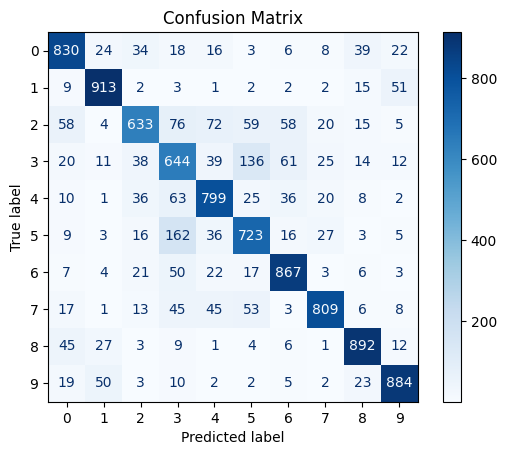

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_pred = np.argmax(model.predict(x_test), axis=-1)

# Calculate confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
